## Deep Learning

In [10]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             classification_report, confusion_matrix, roc_curve, auc)
import matplotlib.pyplot as plt
import seaborn as sns

# reproducibility
RNG_SEED = 42
np.random.seed(RNG_SEED)

In [2]:
csv_path = "archive/english.csv"
df = pd.read_csv(csv_path)
print("Columns:", df.columns.tolist())
print(df.head())

Columns: ['image', 'label']
                image label
0  Img/img001-001.png     0
1  Img/img001-002.png     0
2  Img/img001-003.png     0
3  Img/img001-004.png     0
4  Img/img001-005.png     0


In [3]:
# params
ROOT = "archive"          # csv paths already contain "Img/..." so join ROOT + df['image']
IMG_SIZE = (28, 28)       # width, height

images = []
labels = []
missing = []

for idx, row in df.iterrows():
    img_rel = row["image"]       # e.g. "Img/img001-001.png"
    label_raw = row["label"]     # may be int-like or str
    img_path = os.path.join(ROOT, img_rel)
    if not os.path.exists(img_path):
        missing.append(img_path)
        continue
    im = Image.open(img_path).convert("L")        # grayscale
    im = im.resize(IMG_SIZE)                      # resize
    arr = np.asarray(im, dtype=np.float32).flatten() / 255.0
    images.append(arr)
    labels.append(label_raw)

print("Missing files (count):", len(missing))
X = np.vstack(images)   # shape (N, D)
y_raw = np.array(labels)  # raw labels (strings or numbers)
print("Loaded X:", X.shape, " y:", y_raw.shape, " unique labels:", np.unique(y_raw).shape[0])


Missing files (count): 0
Loaded X: (3410, 784)  y: (3410,)  unique labels: 62


In [4]:
# encode to 0..C-1 for indexing in perceptron
le = LabelEncoder()
y = le.fit_transform(y_raw)   # y is integer array

# stratified splits
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RNG_SEED, stratify=y)

# carve out validation from training
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=RNG_SEED, stratify=y_train_full)

print("Shapes -> train:", X_train.shape, y_train.shape,
      "val:", X_val.shape, y_val.shape, "test:", X_test.shape, y_test.shape)
print("Classes (label -> idx) example:", list(zip(le.classes_[:8], range(8))))


Shapes -> train: (2182, 784) (2182,) val: (546, 784) (546,) test: (682, 784) (682,)
Classes (label -> idx) example: [(np.str_('0'), 0), (np.str_('1'), 1), (np.str_('2'), 2), (np.str_('3'), 3), (np.str_('4'), 4), (np.str_('5'), 5), (np.str_('6'), 6), (np.str_('7'), 7)]


In [13]:
class PLA:
    def __init__(self, input_dim, n_classes, lr=0.01, epochs=10):
        self.W = np.zeros((n_classes, input_dim))
        self.lr = lr
        self.epochs = epochs
        self.errors_ = []   # track misclassifications
    
    def fit(self, X, y):
        for _ in range(self.epochs):
            errors = 0
            for xi, target in zip(X, y):
                scores = self.W @ xi
                y_pred = np.argmax(scores)
                if y_pred != target:
                    self.W[target] += self.lr * xi
                    self.W[y_pred] -= self.lr * xi
                    errors += 1
            self.errors_.append(errors / len(y))  # error rate per epoch

    def predict(self, X):
        scores = self.W @ X.T
        return np.argmax(scores, axis=0)


In [14]:
# Hyperparameter search
lr_values = [0.1, 0.01, 0.001]
epoch_values = [10, 20, 50]

best_acc = 0
best_params = None
best_model = None

for lr in lr_values:
    for ep in epoch_values:
        pla = PLA(input_dim=X_train.shape[1], n_classes=len(le.classes_), lr=lr, epochs=ep)
        pla.fit(X_train, y_train)
        val_preds = pla.predict(X_val)
        acc = accuracy_score(y_val, val_preds)
        print(f"lr={lr}, epochs={ep}, val_acc={acc:.4f}")
        if acc > best_acc:
            best_acc = acc
            best_params = (lr, ep)
            best_model = pla

print("\nBest Params:", best_params, "Validation Accuracy:", best_acc)


lr=0.1, epochs=10, val_acc=0.0916
lr=0.1, epochs=20, val_acc=0.1355
lr=0.1, epochs=50, val_acc=0.1667
lr=0.01, epochs=10, val_acc=0.0916
lr=0.01, epochs=20, val_acc=0.1355
lr=0.01, epochs=50, val_acc=0.1667
lr=0.001, epochs=10, val_acc=0.0916
lr=0.001, epochs=20, val_acc=0.1355
lr=0.001, epochs=50, val_acc=0.1667

Best Params: (0.1, 50) Validation Accuracy: 0.16666666666666666


In [15]:
# Test evaluation using best PLA
pla_preds = best_model.predict(X_test)



PLA Test Accuracy: 0.15102639296187684

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.12      0.36      0.19        11
           2       0.00      0.00      0.00        11
           3       0.10      0.18      0.13        11
           4       0.00      0.00      0.00        11
           5       0.06      0.55      0.11        11
           6       1.00      0.09      0.17        11
           7       1.00      0.09      0.17        11
           8       0.00      0.00      0.00        11
           9       0.00      0.00      0.00        11
           A       0.00      0.00      0.00        11
           B       1.00      0.09      0.17        11
           C       0.00      0.00      0.00        11
           D       0.00      0.00      0.00        11
           E       0.00      0.00      0.00        11
           F       0.00      0.00      0.00        11
           G    

/home/pranesh/Downloads/ML Lab/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/pranesh/Downloads/ML Lab/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/pranesh/Downloads/ML Lab/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

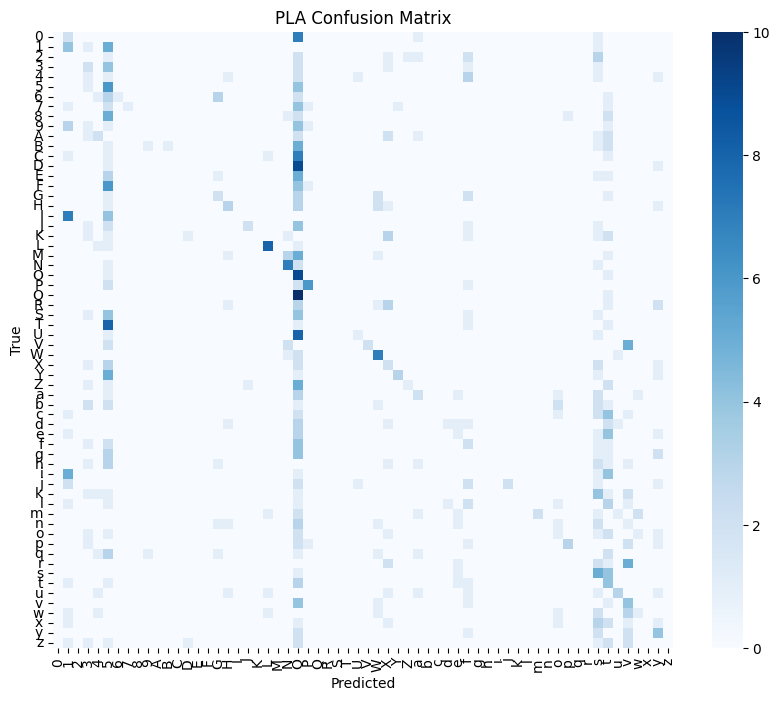

In [16]:

# --- Basic Metrics ---
print("\nPLA Test Accuracy:", accuracy_score(y_test, pla_preds))
print("\nClassification Report:\n", classification_report(y_test, pla_preds, target_names=le.classes_))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, pla_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("PLA Confusion Matrix")
plt.show()


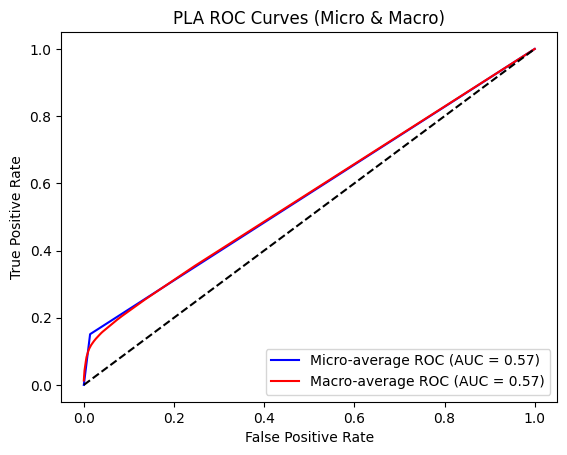

In [17]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize labels for ROC
y_test_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))
pla_preds_bin = label_binarize(pla_preds, classes=np.arange(len(le.classes_)))

# Micro-average ROC
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), pla_preds_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Macro-average ROC
fpr_dict, tpr_dict, roc_auc_dict = {}, {}, {}
for i in range(len(le.classes_)):
    fpr_dict[i], tpr_dict[i], _ = roc_curve(y_test_bin[:, i], pla_preds_bin[:, i])
    roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])

all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(len(le.classes_))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(le.classes_)):
    mean_tpr += np.interp(all_fpr, fpr_dict[i], tpr_dict[i])
mean_tpr /= len(le.classes_)
roc_auc_macro = auc(all_fpr, mean_tpr)

# Plot ROC
plt.figure()
plt.plot(fpr_micro, tpr_micro, label=f"Micro-average ROC (AUC = {roc_auc_micro:.2f})", color="blue")
plt.plot(all_fpr, mean_tpr, label=f"Macro-average ROC (AUC = {roc_auc_macro:.2f})", color="red")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("PLA ROC Curves (Micro & Macro)")
plt.legend(loc="lower right")
plt.show()


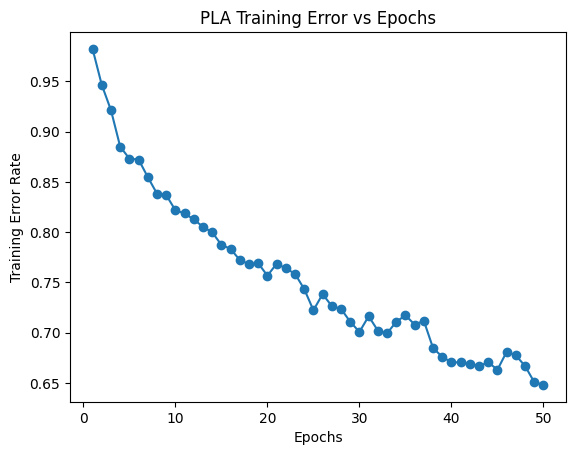

In [18]:
plt.figure()
plt.plot(range(1, len(best_model.errors_)+1), best_model.errors_, marker="o")
plt.xlabel("Epochs")
plt.ylabel("Training Error Rate")
plt.title("PLA Training Error vs Epochs")
plt.show()
